# Milestone 3

In [1]:
# Imports
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler

In [2]:
# Read data
voter_blocks_all = pd.read_csv('../data/MA_l2_2022stats_2020block/MA_l2_2022stats_2020block.csv', low_memory=False).set_index('geoid20')
voter_blocks_all.shape

(107292, 395)

In [3]:
# Group demographic columns together
registered = ['total_reg']
age = ['age_18_19', 'age_20_24', 'age_25_29','age_30_34','age_35_44', 'age_45_54', 'age_55_64', 'age_65_74','age_75_84', 'age_85over']
gender = [ 'voters_gender_m', 'voters_gender_f', 'voters_gender_unknown'] 
party = ['party_npp', 'party_dem', 'party_rep','party_lib', 'party_grn', 'party_con', 'party_ain', 'party_scl','party_oth', 'party_unk']
ethnicity1 = ['eth1_eur', 'eth1_hisp', 'eth1_aa',
                'eth1_esa', 'eth1_oth', 'eth1_unk']
ethnicity2 = ['eth2_euro', 'eth2_64',
                'eth2_93', 'eth2_10', 'eth2_30', 'eth2_23', 'eth2_66', 'eth2_34',
                'eth2_21', 'eth2_35', 'eth2_14', 'eth2_12', 'eth2_55', 'eth2_13',
                'eth2_32', 'eth2_61', 'eth2_85', 'eth2_29', 'eth2_33', 'eth2_38',
                'eth2_15', 'eth2_57', 'eth2_19', 'eth2_26', 'eth2_59', 'eth2_unk']
languages = ['languages_description_english', 'languages_description_spanish',
                'languages_description_portuguese',
                'languages_description_chinese', 'languages_description_italian',
                'languages_description_vietnamese', 'languages_description_other',
                'languages_description_unknown']
income = ['commercialdata_estimatedhhincomeamount_avg']


# Group variables related to the 2020 presidential election
presidential_2020 = ['g20201103_voted_all', 'g20201103_reg_all', 'g20201103_pct_voted_all',
                    'g20201103_voted_gender_m', 'g20201103_reg_gender_m',
                    'g20201103_pct_voted_gender_m', 'g20201103_voted_gender_f',
                    'g20201103_reg_gender_f', 'g20201103_pct_voted_gender_f',
                    'g20201103_voted_gender_unk', 'g20201103_reg_gender_unk',
                    'g20201103_pct_voted_gender_unk', 'g20201103_voted_eur',
                    'g20201103_reg_eur', 'g20201103_pct_voted_eur', 'g20201103_voted_hisp',
                    'g20201103_reg_hisp', 'g20201103_pct_voted_hisp', 'g20201103_voted_aa',
                    'g20201103_reg_aa', 'g20201103_pct_voted_aa', 'g20201103_voted_esa',
                    'g20201103_reg_esa', 'g20201103_pct_voted_esa', 'g20201103_voted_oth',
                    'g20201103_reg_oth', 'g20201103_pct_voted_oth', 'g20201103_voted_unk',
                    'g20201103_reg_unk', 'g20201103_pct_voted_unk']

## Data Cleaning and Processing

### Missingness

Issues to resolve:

- 'NO BLOCK ASSIGNMENT' entries

We are choosing to ignore and drop these values because of inappropriate assumptions that need to be made if trying to disaggregate.

Similarly, using counties as our unit of observation is difficult due to there only being 14 counties.

It seems as though counties with lower population have higher proportion of unassigned voters.

We will also explore the excluded data to determine which population groups we might be disproportionately excluding.

- Missing income data 

Mean income of the Block Group that the Census Block belongs to, weighted by the total number of voters registered.

- Null percentages

Drop Census Blocks that have zero population, useless for our analysis.

In [4]:
# Drop 'NO BLOCK ASSIGNMENT' entries
voter_blocks = voter_blocks_all[~voter_blocks_all.index.str.contains('NO BLOCK ASSIGNMENT')].copy()

# Drop Census Blocks with zero voters registered during the 2020 presidential election
voter_blocks = voter_blocks[voter_blocks['g20201103_reg_all'] != 0]

# Impute mean HH income with mean of block group
wm = lambda x: (
    np.average(x.dropna(), weights=voter_blocks.loc[x.dropna().index, 'total_reg'])
    if voter_blocks.loc[x.dropna().index, 'total_reg'].sum() > 0
    else np.nan
)
voter_blocks['block_group_id'] = voter_blocks.index.str[:12]
wm_bg_hh_income = voter_blocks.groupby('block_group_id')[['total_reg','commercialdata_estimatedhhincomeamount_avg']].agg(wm_bg_hh_income=('commercialdata_estimatedhhincomeamount_avg',wm))
voter_blocks = voter_blocks.join(wm_bg_hh_income, on='block_group_id')
voter_blocks['mean_hh_income'] = voter_blocks.apply(lambda row: row['commercialdata_estimatedhhincomeamount_avg'] if pd.notna(row['commercialdata_estimatedhhincomeamount_avg']) else row['wm_bg_hh_income'], axis=1)

In [5]:
print(f'After imputation, there are a total of {len(voter_blocks[voter_blocks['mean_hh_income'].isna()].index)} Census Blocks still missing income data, with {voter_blocks[voter_blocks['mean_hh_income'].isna()]['total_reg'].sum()} voters in those Census Blocks ({voter_blocks[voter_blocks['mean_hh_income'].isna()]['total_reg'].sum()/voter_blocks['total_reg'].sum():.5%} of the total).')

After imputation, there are a total of 5 Census Blocks still missing income data, with 14 voters in those Census Blocks (0.00031% of the total).


In [6]:
# Choose to drop NaN values for income due to low number of voters in these blocks.
voter_blocks = voter_blocks.dropna(subset='mean_hh_income')

In [7]:
print('\t\t\tBefore processing\tAfter processing')
print(f'Census Blocks:\t\t{len(voter_blocks_all.index):,d}\t\t\t{len(voter_blocks.index):,d}')
print(f'Voters Registered:\t{voter_blocks_all['total_reg'].sum():,d}\t\t{voter_blocks['total_reg'].sum():,d}')
print(f'\n{(len(voter_blocks_all.index) - len(voter_blocks.index)) / len(voter_blocks_all.index):.2%} of Census Blocks were dropped.')
print(f'{(voter_blocks_all['total_reg'].sum() - voter_blocks['total_reg'].sum()) / voter_blocks_all['total_reg'].sum():.2%} of total registered voters were dropped.')

			Before processing	After processing
Census Blocks:		107,292			86,629
Voters Registered:	4,606,321		4,532,271

19.26% of Census Blocks were dropped.
1.61% of total registered voters were dropped.


### Imbalance

Issues to resolve:

- Uneven distribution of voters among Census Blocks.

Using percentage values may introduce variation that are too large for Census Blocks with very little population.

We will choose to scale the data using RobustScaler.

In [8]:
predictors = [*registered, *age, *gender, *party, *ethnicity1, *languages, 'mean_hh_income']
# Other potential response variables could be g20201103_voted_all or those who voted and are a part of a certain demographic group
response = 'g20201103_pct_voted_all'
display(voter_blocks[predictors].describe())
display(voter_blocks[response].describe())

,total_reg,age_18_19,age_20_24,age_25_29,age_30_34,age_35_44,age_45_54,age_55_64,age_65_74,age_75_84,...,eth1_unk,languages_description_english,languages_description_spanish,languages_description_portuguese,languages_description_chinese,languages_description_italian,languages_description_vietnamese,languages_description_other,languages_description_unknown,mean_hh_income
count,86629.000000,86629.000000,86629.000000,86629.000000,86629.000000,86629.000000,86629.000000,86629.000000,86629.000000,86629.000000,...,86629.000000,86629.000000,86629.000000,86629.000000,86629.000000,86629.000000,86629.000000,86629.000000,86629.000000,86629.000000
mean,52.318173,0.767722,3.817255,4.306860,4.457676,8.059126,7.756029,9.300523,7.777511,4.390470,...,5.618223,23.195269,0.778100,0.198836,0.133766,0.109963,0.092602,0.424396,27.385241,119417.835122
std,68.430598,1.445426,6.018265,7.461336,7.466268,11.221144,10.697440,12.767145,11.443843,8.244904,...,8.469770,32.418691,2.178751,0.782479,0.733831,0.428534,0.488534,1.141944,37.582621,46326.140685
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6000.000000
25%,15.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000,1.000000,...,1.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,86942.000000
50%,32.000000,0.000000,2.000000,2.000000,2.000000,5.000000,5.000000,6.000000,4.000000,2.000000,...,3.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.000000,114299.000000
75%,62.000000,1.000000,5.000000,5.000000,5.000000,10.000000,10.000000,11.000000,9.000000,5.000000,...,7.000000,27.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.000000,148139.000000
max,1411.000000,95.000000,453.000000,257.000000,284.000000,250.000000,235.000000,241.000000,245.000000,245.000000,...,225.000000,627.000000,76.000000,29.000000,64.000000,19.000000,19.000000,57.000000,917.000000,313164.000000


count    86629.000000
mean         0.806954
std          0.163218
min          0.000000
25%          0.744700
50%          0.840000
75%          0.909100
max          1.000000
Name: g20201103_pct_voted_all, dtype: float64

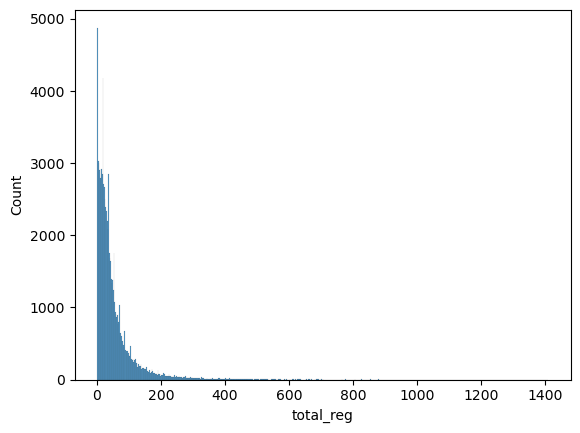

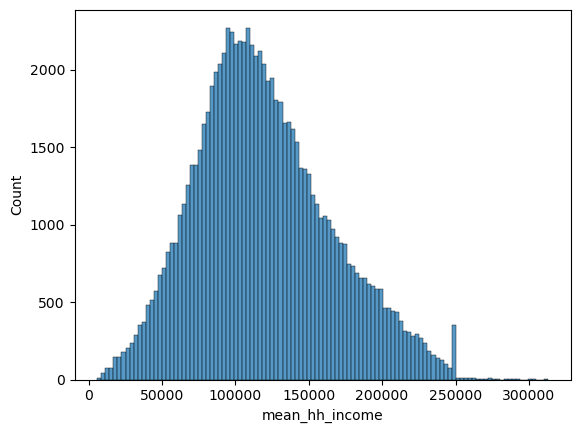

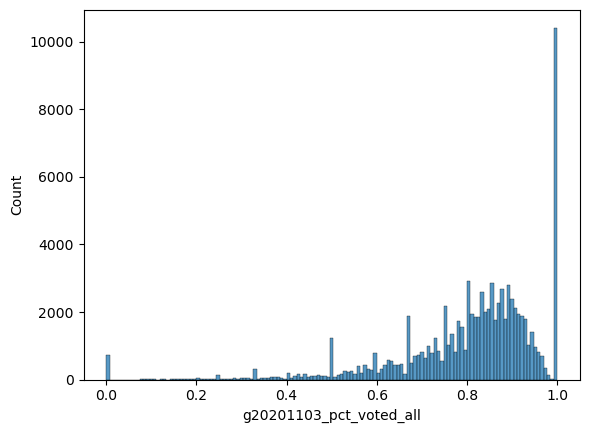

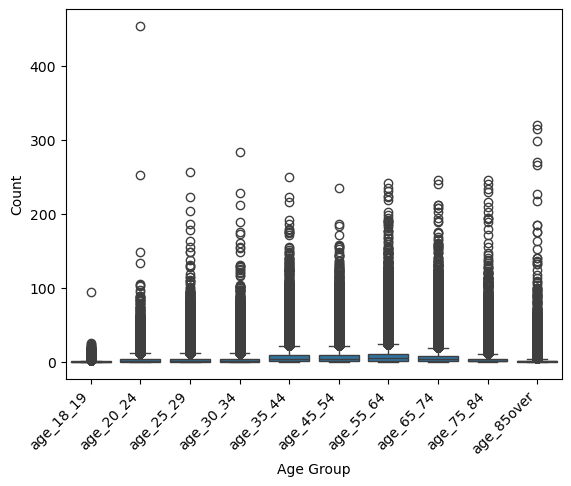

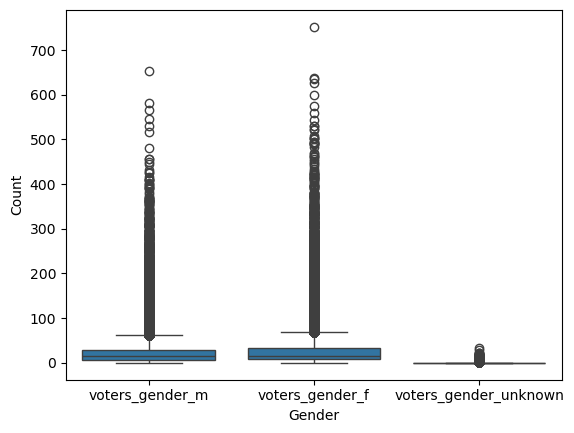

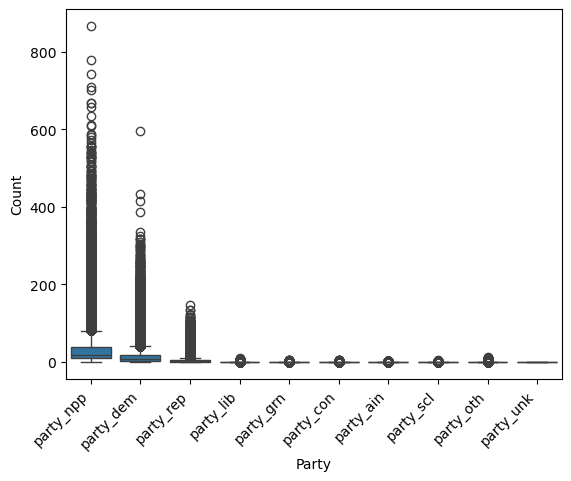

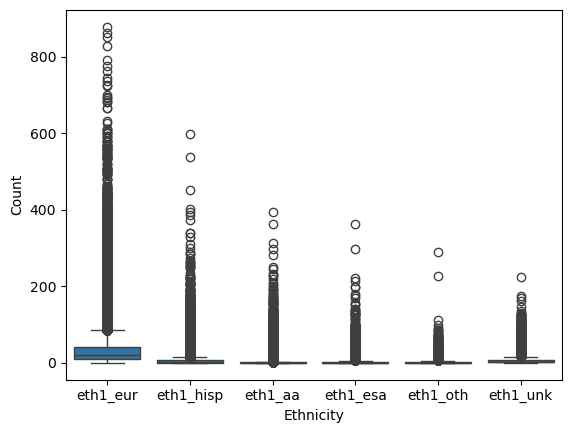

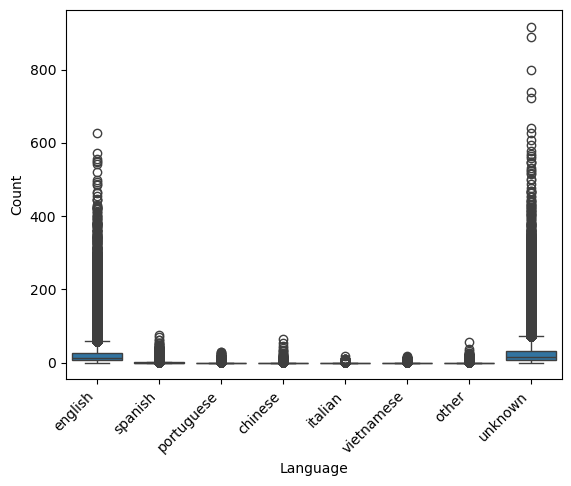

In [9]:
# Before transformation

sns.histplot(voter_blocks, x='total_reg')
# plt.yscale('log')
plt.show()

sns.histplot(voter_blocks, x='mean_hh_income')
# plt.yscale('log')
plt.show()

sns.histplot(voter_blocks, x=response)
# plt.yscale('log')
plt.show()

sns.boxplot(voter_blocks.melt(value_vars=age,var_name='Age Group',value_name='Count'),x='Age Group', y='Count')
plt.xticks(rotation=45, ha='right')
# plt.yscale('log')
plt.show()

sns.boxplot(voter_blocks.melt(value_vars=gender,var_name='Gender',value_name='Count'), x='Gender', y='Count')
# plt.yscale('log')
plt.show()

sns.boxplot(voter_blocks.melt(value_vars=party,var_name='Party',value_name='Count'), x='Party', y='Count')
plt.xticks(rotation=45, ha='right')
# plt.yscale('log')
plt.show()

sns.boxplot(voter_blocks.melt(value_vars=ethnicity1,var_name='Ethnicity',value_name='Count'), x='Ethnicity', y='Count')
# plt.yscale('log')
plt.show()

sns.boxplot(voter_blocks.melt(value_vars=languages,var_name='Language',value_name='Count'), x='Language', y='Count')
plt.xticks(ticks=np.arange(len(languages)),labels=[lang[len('languages_description_'):] for lang in languages], rotation=45, ha='right')
# plt.yscale('log')
plt.show()

In [10]:
voter_blocks[predictors] = RobustScaler().fit_transform(X=voter_blocks[predictors])
voter_blocks

,total_reg,age_18_19,age_20_24,age_25_29,age_30_34,age_35_44,age_45_54,age_55_64,age_65_74,age_75_84,...,pp20200303_pct_voted_esa,pp20200303_voted_oth,pp20200303_reg_oth,pp20200303_pct_voted_oth,pp20200303_voted_unk,pp20200303_reg_unk,pp20200303_pct_voted_unk,block_group_id,wm_bg_hh_income,mean_hh_income
geoid20,,,,,,,,,,,,,,,,,,,,,
250277614022048,-0.553191,0.0,-0.4,-0.4,-0.4,-0.250,-0.625,-0.555556,-0.285714,-0.50,...,1.0,0,0,NaN,1,2,0.50,250277614022,144781.884170,1.280569
250277614022043,-0.553191,0.0,-0.4,-0.4,-0.4,-0.500,-0.125,-0.555556,-0.571429,-0.50,...,0.0,0,0,NaN,0,0,NaN,250277614022,144781.884170,0.545239
250277614022042,-0.553191,0.0,-0.4,-0.4,-0.2,-0.375,-0.250,-0.666667,-0.571429,-0.50,...,NaN,0,0,NaN,0,0,NaN,250277614022,144781.884170,0.500041
250277614022041,-0.595745,0.0,-0.2,-0.4,-0.4,-0.625,-0.625,-0.444444,-0.428571,-0.50,...,NaN,0,0,NaN,0,0,NaN,250277614022,144781.884170,2.217445
250277614022040,0.234043,2.0,0.4,0.2,0.0,-0.250,1.375,0.444444,-0.285714,-0.25,...,0.5,0,0,NaN,1,4,0.25,250277614022,144781.884170,0.106639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250010101001014,-0.574468,0.0,-0.4,-0.4,-0.4,-0.625,-0.625,-0.333333,-0.571429,-0.25,...,NaN,0,0,NaN,0,1,0.00,250010101001,127870.090705,-0.680916
250010101001011,0.404255,0.0,0.0,0.2,-0.4,-0.125,0.750,0.333333,1.857143,0.75,...,NaN,0,0,NaN,3,5,0.60,250010101001,127870.090705,-0.066392
250010101001008,0.234043,0.0,-0.4,-0.2,-0.2,-0.625,-0.250,0.888889,0.714286,3.00,...,0.5,0,0,NaN,5,5,1.00,250010101001,127870.090705,-0.103322


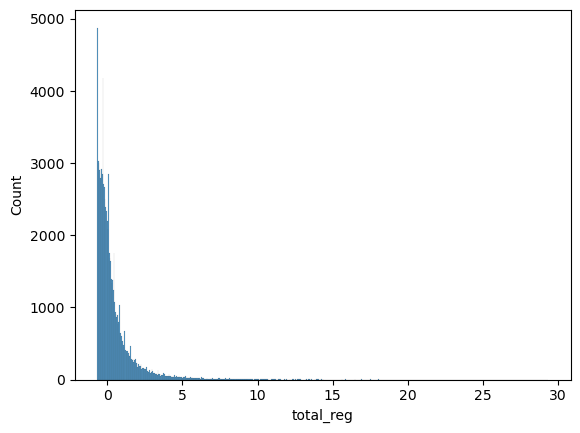

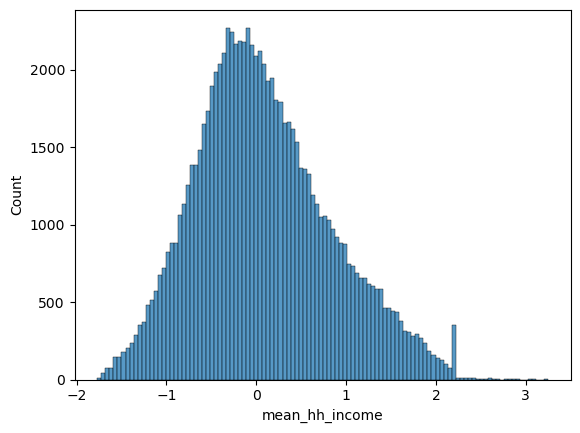

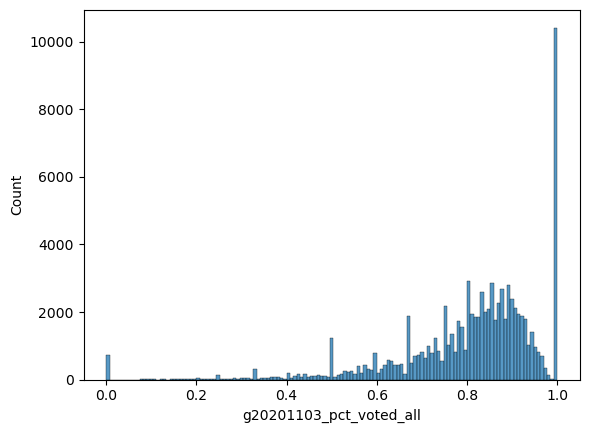

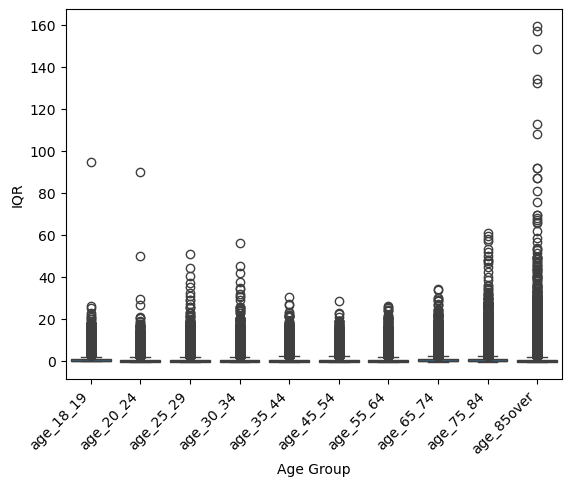

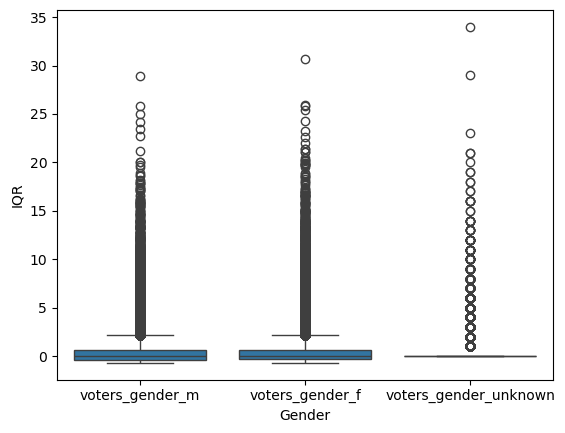

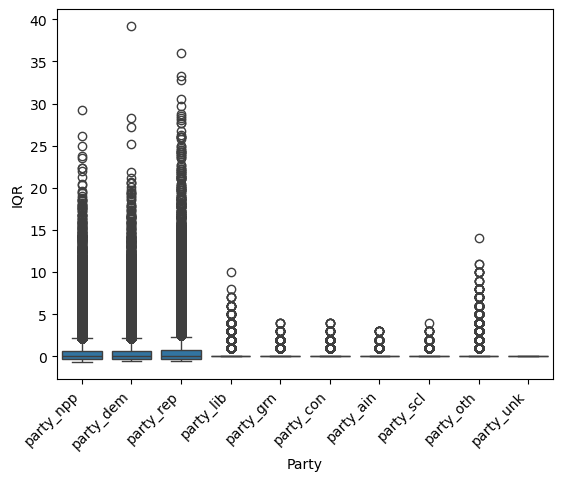

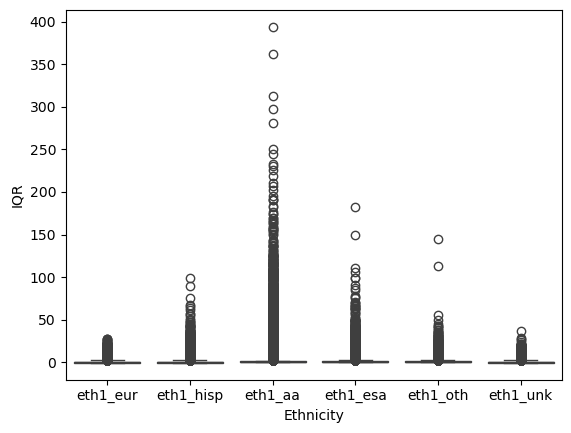

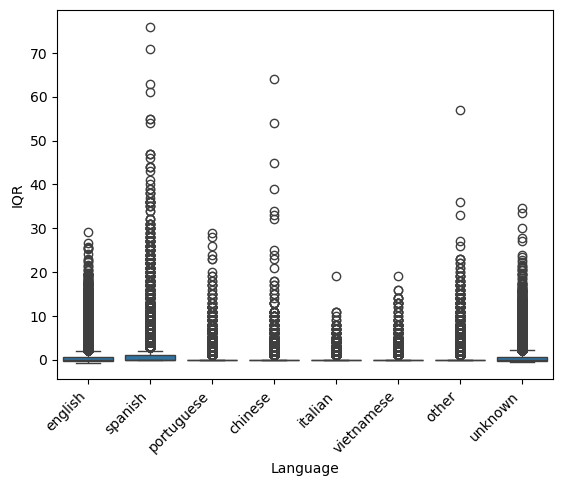

In [11]:
# After transformation

sns.histplot(voter_blocks, x='total_reg')
# plt.yscale('log')
plt.show()

sns.histplot(voter_blocks, x='mean_hh_income')
# plt.yscale('log')
plt.show()

sns.histplot(voter_blocks, x=response)
# plt.yscale('log')
plt.show()

sns.boxplot(voter_blocks.melt(value_vars=age,var_name='Age Group',value_name='IQR'),x='Age Group', y='IQR')
plt.xticks(rotation=45, ha='right')
# plt.yscale('log')
plt.show()

sns.boxplot(voter_blocks.melt(value_vars=gender,var_name='Gender',value_name='IQR'), x='Gender', y='IQR')
# plt.yscale('log')
plt.show()

sns.boxplot(voter_blocks.melt(value_vars=party,var_name='Party',value_name='IQR'), x='Party', y='IQR')
plt.xticks(rotation=45, ha='right')
# plt.yscale('log')
plt.show()

sns.boxplot(voter_blocks.melt(value_vars=ethnicity1,var_name='Ethnicity',value_name='IQR'), x='Ethnicity', y='IQR')
# plt.yscale('log')
plt.show()

sns.boxplot(voter_blocks.melt(value_vars=languages,var_name='Language',value_name='IQR'), x='Language', y='IQR')
plt.xticks(ticks=np.arange(len(languages)),labels=[lang[len('languages_description_'):] for lang in languages], rotation=45, ha='right')
# plt.yscale('log')
plt.show()

## Exploratory Data Analysis

In [12]:
# Use voter_blocks for further analysis, predictors are scaled with RobustScaler
voter_blocks

,total_reg,age_18_19,age_20_24,age_25_29,age_30_34,age_35_44,age_45_54,age_55_64,age_65_74,age_75_84,...,pp20200303_pct_voted_esa,pp20200303_voted_oth,pp20200303_reg_oth,pp20200303_pct_voted_oth,pp20200303_voted_unk,pp20200303_reg_unk,pp20200303_pct_voted_unk,block_group_id,wm_bg_hh_income,mean_hh_income
geoid20,,,,,,,,,,,,,,,,,,,,,
250277614022048,-0.553191,0.0,-0.4,-0.4,-0.4,-0.250,-0.625,-0.555556,-0.285714,-0.50,...,1.0,0,0,NaN,1,2,0.50,250277614022,144781.884170,1.280569
250277614022043,-0.553191,0.0,-0.4,-0.4,-0.4,-0.500,-0.125,-0.555556,-0.571429,-0.50,...,0.0,0,0,NaN,0,0,NaN,250277614022,144781.884170,0.545239
250277614022042,-0.553191,0.0,-0.4,-0.4,-0.2,-0.375,-0.250,-0.666667,-0.571429,-0.50,...,NaN,0,0,NaN,0,0,NaN,250277614022,144781.884170,0.500041
250277614022041,-0.595745,0.0,-0.2,-0.4,-0.4,-0.625,-0.625,-0.444444,-0.428571,-0.50,...,NaN,0,0,NaN,0,0,NaN,250277614022,144781.884170,2.217445
250277614022040,0.234043,2.0,0.4,0.2,0.0,-0.250,1.375,0.444444,-0.285714,-0.25,...,0.5,0,0,NaN,1,4,0.25,250277614022,144781.884170,0.106639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250010101001014,-0.574468,0.0,-0.4,-0.4,-0.4,-0.625,-0.625,-0.333333,-0.571429,-0.25,...,NaN,0,0,NaN,0,1,0.00,250010101001,127870.090705,-0.680916
250010101001011,0.404255,0.0,0.0,0.2,-0.4,-0.125,0.750,0.333333,1.857143,0.75,...,NaN,0,0,NaN,3,5,0.60,250010101001,127870.090705,-0.066392
250010101001008,0.234043,0.0,-0.4,-0.2,-0.2,-0.625,-0.250,0.888889,0.714286,3.00,...,0.5,0,0,NaN,5,5,1.00,250010101001,127870.090705,-0.103322
